### Initial package imports

In [32]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

## Initial files being read in and dataset creation

In [13]:
pd.set_option('display.float_format', '{:.6f}'.format)
# Read the data
main_df = pd.read_csv('Data/Cleaned_Indices_Assignment1.csv', sep=';')

# Read the interest rate data
#interest_rate_df = pd.read_csv('Data/ECB_Rates_2012_to_2022.csv', sep=';')
interest_rate_bond_df = pd.read_csv('Data/ECB_Data_10yr_Treasury_bond.csv', sep=',')

# Convert date columns to datetime format for proper merging
main_df['Date'] = pd.to_datetime(main_df['Date'], format='%d-%m-%Y')
#interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['Date'], format='%d-%m-%Y')
#gov_bond_investment_df['Date'] = pd.to_datetime(gov_bond_investment_df['Date'], format='%Y-%m-%d')
interest_rate_bond_df['Date'] = pd.to_datetime(interest_rate_bond_df['Date'], format='%Y-%m-%d')

# Merge the dataframes on the Date column
main_df = pd.merge(main_df, interest_rate_bond_df, on='Date', how='left')
#main_df = pd.merge(main_df, gov_bond_investment_df, on='Date', how='left')

# Remove rows where the bond does not have a yield curve spot rate (Market closed?)
main_df = main_df.dropna(axis=0, subset=['Yield curve spot rate, 10-year maturity - Government bond'])

# Filter the dataframe to start from 2012-01-04
main_df = main_df[main_df['Date'] >= '2012-01-04']
main_df = main_df.reset_index(drop=True)


In [14]:
# Add a column for the interest bond value per day
days_per_annum = 365
interest_bond = 1500000

# Initialize the arrays with appropriate lengths matching the DataFrame
interest_bond_vector = np.zeros(len(main_df))
interest_bond_profit_vector = np.zeros(len(main_df))
interest_bond_loss_vector = np.zeros(len(main_df))
daily_rates = np.zeros(len(main_df))

# Set initial value
interest_bond_vector[0] = interest_bond


# Calculate bond values day by day based on the daily yield rate
for i in range(len(main_df)):
    # Adding 1.5% to account for the credit risk spread
    daily_rate = (((main_df['Yield curve spot rate, 10-year maturity - Government bond'].iloc[i] + 1.5) / (days_per_annum)) * (7/5)) / 100
    daily_rates[i] = daily_rate
    
    if i > 0:
        previous_value = interest_bond_vector[i-1]
        current_value = previous_value * (1 + daily_rate)
        interest_bond_vector[i] = current_value
        
        # Calculate change, profit/loss and return
        change = current_value - previous_value
        interest_bond_profit_vector[i] = change
        interest_bond_loss_vector[i] = -change

# Add vectors to the dataframe
main_df['Interest_Bond'] = interest_bond_vector
main_df['Interest_Bond_Profit'] = interest_bond_profit_vector
main_df['Interest_Bond_Loss'] = interest_bond_loss_vector
main_df['Interest_Bond_daily_rate'] = daily_rates


## Portfolio details

### Instruments:
- **S&P500**
- **DAX40**
- **NIKKEI**
- **EU Government Bond (10-year maturity, AAA-rated)**

### Invested amount:
- **10,000,000 EURO**

### Period:
- **01/01/2012 - 31/12/2022**

### Weights:
- **S&P500**: 0.4  
- **DAX40**: 0.3  
- **NIKKEI**: 0.15  
- **EU Government Bond**: 0.15  

### Measures:
- **Value at Risk (VaR)**: 1, 5, 10 days  
- **Expected Shortfall (ES)**  



In [15]:
main_df


,Date,S&P500_Closing,Dax40_Closing,Nikkei_Closing,U_S&P500_Returns,U_Dax40_Returns,U_Nikkei_Returns,U_S&P500_Loss,U_Dax40_Loss,U_Nikkei_Loss,...,TIME PERIOD,"Yield curve spot rate, 10-year maturity - Government bond",Interest_Bond,Interest_Bond_Profit,Interest_Bond_Loss,Interest_Bond_daily_rate,SP500_Investment,DAX40_Investment,NIKKEI_Investment,EU_BOND_Investment
0,2012-01-04,1277.300000,6111.550000,8560.110000,NaN,NaN,NaN,NaN,NaN,NaN,...,04 Jan 2012,2.776691,1500000.000000,0.000000,0.000000,0.000164,NaN,NaN,NaN,1500000.000000
1,2012-01-05,1281.060000,6095.990000,8488.710000,0.002939,-0.002549,-0.008376,-3.760000,15.560000,71.400000,...,05 Jan 2012,2.784807,1500246.523142,246.523142,-246.523142,0.000164,5189897.180583,2992352.262000,148944667.328699,1500246.523142
2,2012-01-06,1277.810000,6057.920000,8390.350000,-0.002540,-0.006265,-0.011655,3.250000,38.070000,98.360000,...,06 Jan 2012,2.788371,1500493.291886,246.768744,-246.768744,0.000164,5179533.786296,2973606.159562,148926943.509066,1500493.291886
3,2012-01-09,1280.700000,6017.230000,8390.350000,0.002259,-0.006739,0.000000,-2.890000,40.690000,0.000000,...,09 Jan 2012,2.757489,1500738.323863,245.031977,-245.031977,0.000163,5188699.359796,2953565.582481,148926943.509066,1500738.323863
4,2012-01-10,1292.080000,6162.980000,8422.260000,0.008847,0.023933,0.003796,-11.380000,-145.750000,-31.910000,...,10 Jan 2012,2.746027,1500982.736072,244.412209,-244.412209,0.000163,5224622.209432,3024254.466714,148932706.981779,1500982.736072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,2022-12-23,3844.820000,13940.930000,26235.250000,0.005851,0.001929,-0.010338,-22.430000,-26.860000,272.620000,...,23 Dec 2022,2.464312,1898481.681703,288.631268,-288.631268,0.000152,11203387.897754,5587239.551284,150353000.311487,1898481.681703
2801,2022-12-27,3829.250000,13995.100000,26447.870000,-0.004058,0.003878,0.001589,15.570000,-54.170000,-42.000000,...,27 Dec 2022,2.501054,1898773.032356,291.350653,-291.350653,0.000153,11160667.822429,5608907.709937,150354684.265090,1898773.032356
2802,2022-12-28,3783.220000,13925.600000,26340.500000,-0.012093,-0.004978,-0.004068,46.030000,69.500000,107.370000,...,28 Dec 2022,2.522043,1899065.956342,292.923986,-292.923986,0.000154,11033498.028193,5580984.351838,150350399.156588,1899065.956342
2803,2022-12-29,3849.280000,14071.720000,26093.670000,0.017311,0.010438,-0.009415,-66.060000,-146.120000,246.830000,...,29 Dec 2022,2.526705,1899359.265102,293.308760,-293.308760,0.000154,11212633.819784,5639239.989196,150340415.890085,1899359.265102


## Portfolio values 

In [5]:
# initial investment 
weigths = {
    'S&P500': 0.4,
    'DAX40': 0.3,
    'NIKKEI': 0.15,
    'EU-BOND': 0.15,
}

starting_investment = 10000000  # 10 million euros
starting_date = '2012-01-04'

# Filter the main_df for the starting date
starting_row = main_df[main_df['Date'] == starting_date]

# Extract the exchange rates for the starting date
usd_to_eur = float(starting_row['USD/EUR'].iloc[0])
jpy_to_eur = float(starting_row['JPY/EUR'].iloc[0])

# Calculate the invested amounts
invested_amount_SP500 = starting_investment * weigths['S&P500'] / usd_to_eur
invested_amount_DAX40 = starting_investment * weigths['DAX40']
invested_amount_NIKKEI = starting_investment * weigths['NIKKEI'] / jpy_to_eur
invested_amount_EU_BOND = starting_investment * weigths['EU-BOND']

invested_amounts = [
    invested_amount_SP500, #in USD
    invested_amount_DAX40, #in EUR
    invested_amount_NIKKEI, #in JPY
    invested_amount_EU_BOND #in EUR
]

print(invested_amounts)


[5177993.527508091, 3000000.0, 148957298.90764648, 1500000.0]


## Returns Portfolio 

In [6]:
#create a column for the invested amount in the SP500 and multiply by the return of the next day 

main_df['SP500_Investment'] = invested_amount_SP500 * (1 + main_df['C_S&P500_Returns']).cumprod()
main_df['DAX40_Investment'] = invested_amount_DAX40 * (1 + main_df['C_Dax40_Returns']).cumprod()
main_df['NIKKEI_Investment'] = invested_amount_NIKKEI * (1 + main_df['C_Nikkei_Returns']).cumprod()
main_df['EU_BOND_Investment'] = main_df['Interest_Bond']


In [7]:
main_df

,Date,S&P500_Closing,Dax40_Closing,Nikkei_Closing,U_S&P500_Returns,U_Dax40_Returns,U_Nikkei_Returns,U_S&P500_Loss,U_Dax40_Loss,U_Nikkei_Loss,...,TIME PERIOD,"Yield curve spot rate, 10-year maturity - Government bond",Interest_Bond,Interest_Bond_Profit,Interest_Bond_Loss,Interest_Bond_daily_rate,SP500_Investment,DAX40_Investment,NIKKEI_Investment,EU_BOND_Investment
0,2012-01-04,1277.300000,6111.550000,8560.110000,NaN,NaN,NaN,NaN,NaN,NaN,...,04 Jan 2012,2.776691,1500000.000000,0.000000,0.000000,0.001093,NaN,NaN,NaN,1500000.000000
1,2012-01-05,1281.060000,6095.990000,8488.710000,0.002939,-0.002549,-0.008376,-3.760000,15.560000,71.400000,...,05 Jan 2012,2.784807,1501644.571063,1644.571063,-1644.571063,0.001096,5189897.180583,2992352.262000,148944667.328699,1501644.571063
2,2012-01-06,1277.810000,6057.920000,8390.350000,-0.002540,-0.006265,-0.011655,3.250000,38.070000,98.360000,...,06 Jan 2012,2.788371,1503293.052234,1648.481171,-1648.481171,0.001098,5177969.757817,3000047.910562,148957300.410754,1503293.052234
3,2012-01-09,1280.700000,6017.230000,8390.350000,0.002259,-0.006739,0.000000,-2.890000,40.690000,0.000000,...,09 Jan 2012,2.757489,1504925.065642,1632.013408,-1632.013408,0.001086,5177993.485446,2999999.677107,148957298.907646,1504925.065642
4,2012-01-10,1292.080000,6162.980000,8422.260000,0.008847,0.023933,0.003796,-11.380000,-145.750000,-31.910000,...,10 Jan 2012,2.746027,1506552.059682,1626.994041,-1626.994041,0.001081,5177993.527217,2999999.992272,148957298.907646,1506552.059682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,2022-12-23,3844.820000,13940.930000,26235.250000,0.005851,0.001929,-0.010338,-22.430000,-26.860000,272.620000,...,23 Dec 2022,2.464312,3221753.998264,3122.721134,-3122.721134,0.000970,5177993.527508,3000000.000000,148957298.907646,3221753.998264
2801,2022-12-27,3829.250000,13995.100000,26447.870000,-0.004058,0.003878,0.001589,15.570000,-54.170000,-42.000000,...,27 Dec 2022,2.501054,3224926.352880,3172.354616,-3172.354616,0.000985,5177993.527508,3000000.000000,148957298.907646,3224926.352880
2802,2022-12-28,3783.220000,13925.600000,26340.500000,-0.012093,-0.004978,-0.004068,46.030000,69.500000,107.370000,...,28 Dec 2022,2.522043,3228128.480019,3202.127139,-3202.127139,0.000993,5177993.527508,3000000.000000,148957298.907646,3228128.480019
2803,2022-12-29,3849.280000,14071.720000,26093.670000,0.017311,0.010438,-0.009415,-66.060000,-146.120000,246.830000,...,29 Dec 2022,2.526705,3231339.711661,3211.231642,-3211.231642,0.000995,5177993.527508,3000000.000000,148957298.907646,3231339.711661


## Value at Risk (VaR)

In [ ]:
def VaR(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the VaR of the normal model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional) double, degrees of freedom for student-t

    Return value:
        dVaR    double, VaR
    """
    if (df == 0):
        VaR0= st.norm.ppf(alpha)

        VaR= r + s*VaR0
    else:
        VaR0= st.t.ppf(alpha, df= df)

        S2t= df/(df-2)
        c= s / np.sqrt(S2t)
        VaR= r + c*VaR0

    return VaR

## Expected Shortfall (ES)

In [ ]:
def ES(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the ES of the normal/student model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional, default= 0/normal) double, df

    Return value:
        dES     double, ES
    """
    if (df == 0):
        VaR0= st.norm.ppf(alpha)
        ES0= st.norm.pdf(VaR0) / (1-alpha)
        ES= r + s*ES0
    else:
        dVaR0= st.t.ppf(alpha, df= df)
        ES0= st.t.pdf(dVaR0, df= df)*((df + dVaR0**2)/(df-1)) / (1-alpha)

        dS2t= df/(df-2)
        c= s / np.sqrt(dS2t)
        ES= r + c*ES0

    return ES

## Input values 

### Expected returns (daily)

In [ ]:
Mu_SP500 = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_S&P500_Returns'].mean() 
Mu_DAX40= main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Dax40_Returns'].mean() 
Mu_NIKKEI= main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Nikkei_Returns'].mean() 
Mu_EU_BOND= main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['Interest_Bond_daily_rate'].mean() 
Mu= [Mu_SP500, Mu_DAX40, Mu_NIKKEI, Mu_EU_BOND]  
Pmu = weigths['S&P500'] * Mu_SP500 + weigths['DAX40'] * Mu_DAX40 + weigths['NIKKEI'] * Mu_NIKKEI + weigths['EU-BOND'] * Mu_EU_BOND
print(Mu)
print(Pmu)

### Variances

In [ ]:
## variances
var_SP500 = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_S&P500_Returns'].var()
var_DAX40 = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Dax40_Returns'].var()
var_NIKKEI = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Nikkei_Returns'].var()
var_EU_BOND = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['Interest_Bond_daily_rate'].var()
variances = [var_SP500, var_DAX40, var_NIKKEI, var_EU_BOND] 
print(variances)

### Covariance matrix 

In [ ]:
# Filter the data for the relevant date range
filtered_df = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]

# Select the relevant columns for returns
Returns = filtered_df[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']]

# Compute the covariance matrix
CovM = Returns.cov()

# Compute the correlation matrix
CorrM = Returns.corr()

# Print the covariance matrix
print("Covariance Matrix:")
print(CovM)

# Print the correlation matrix
print("\n")  # Add a blank line for better readability
print("Correlation Matrix:")
print(CorrM)


Covariance Matrix:
                          C_S&P500_Returns  C_Dax40_Returns  C_Nikkei_Returns  \
C_S&P500_Returns                  0.000078         0.000063          0.000000   
C_Dax40_Returns                   0.000063         0.000145          0.000000   
C_Nikkei_Returns                  0.000000         0.000000          0.000000   
Interest_Bond_daily_rate         -0.000000         0.000000          0.000000   

                          Interest_Bond_daily_rate  
C_S&P500_Returns                         -0.000000  
C_Dax40_Returns                           0.000000  
C_Nikkei_Returns                          0.000000  
Interest_Bond_daily_rate                  0.000000  


Correlation Matrix:
                          C_S&P500_Returns  C_Dax40_Returns  C_Nikkei_Returns  \
C_S&P500_Returns                  1.000000         0.589185          0.189941   
C_Dax40_Returns                   0.589185         1.000000          0.309195   
C_Nikkei_Returns                  0.189941   

### Portfolio variance/standard deviation 

In [ ]:
# Convert weights to a numpy array
weights = np.array([weigths['S&P500'], weigths['DAX40'], weigths['NIKKEI'], weigths['EU-BOND']])

# Calculate the portfolio variance
Pvar = np.dot(weights.T, np.dot(CovM.values, weights))
Pvol = np.sqrt(Pvar)

print(Pvar)
print(Pvol)

# Value at Risk (VaR)

In [ ]:
def main():
    # Magic numbers
    N= len(main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')])
    P= 50
    
    
    Sy= .30
    vAlpha= [.95, .99]
    iDF= 6

    # Initialisation
    vAlpha= np.array(vAlpha)

    # Estimation
    vVaR= VaR(vAlpha, dMu, dSy)
    vVaRt= VaR(vAlpha, dMu, dSy, df= iDF)
    print ('var, vart:', vVaR, vVaRt)

    vES= ES(vAlpha, dMu, dSy)
    vESt= ES(vAlpha, dMu, dSy, df= iDF)
    print ('es, est:', vES, vESt)

    vN= dMu+dSy*st.norm.rvs(size= 10000000)
    print (f'Simulating Norm, mean= {vN.mean()}, std= {vN.std()}')

    dVaRs= np.quantile(vN, .95)
    vI= vN >= dVaRs
    print (f'Sim, var= {dVaRs}, ES= {vN[vI].mean()}')

    dS2t= iDF/(iDF-2)
    dC= dSy / np.sqrt(dS2t)
    vT= dMu+dC*st.t.rvs(df= iDF, size= 10000000)
    print (f'Simulating t({iDF}), mean= {vT.mean()}, std= {vT.std()}')

    dVaRt= np.quantile(vT, .95)
    vI= vT >= dVaRt
    print (f'Sim, vart= {dVaRt}, ES= {vT[vI].mean()}')

    np.quantile(vT, .99)
    VaR(.95, 0, 1)


## Historical simulation

VaR (S&P500) at 95.0% confidence level: -32.151924
ES (S&P500) at 95.0% confidence level: -52.35510263779528


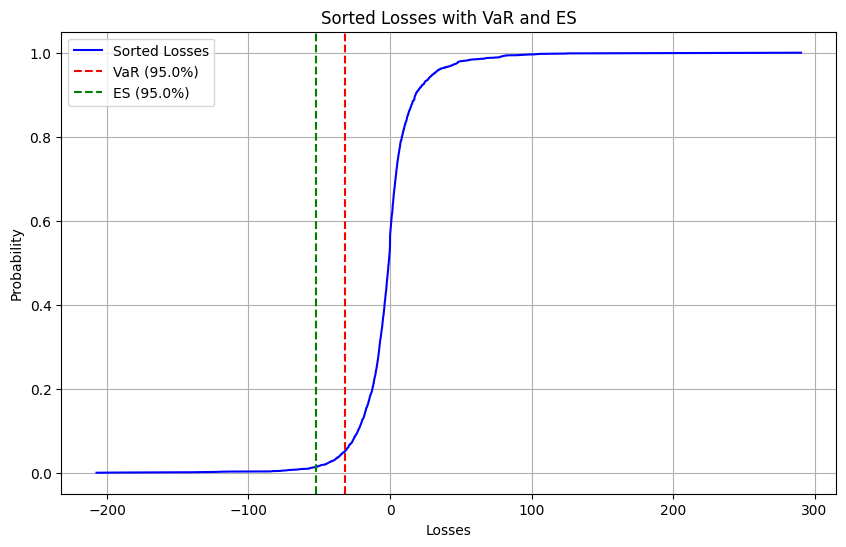

In [33]:
# Define the confidence level, DIT IS NOG GEEN VASTE WAARDE, MEER VOOR GEMAK NU
confidence_level = 0.95

# Extract historical losses for S&P500
sp500_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_S&P500_Loss'].dropna()

# Sort the losses in ascending order
sorted_losses = sp500_losses.sort_values()

# Calculate the index for the VaR based on the confidence level
var_index = int((1 - confidence_level) * len(sorted_losses))

# Calculate VaR
VaR_sp500 = sorted_losses.iloc[var_index]

# Calculate ES (average of losses beyond VaR)
ES_sp500 = sorted_losses.iloc[:var_index].mean()

print(f"VaR (S&P500) at {confidence_level * 100}% confidence level: {VaR_sp500}")
print(f"ES (S&P500) at {confidence_level * 100}% confidence level: {ES_sp500}")

# Plot the sorted losses as a line graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_losses.values, np.linspace(0, 1, len(sorted_losses), endpoint=False), label='Sorted Losses', color='blue')

# Highlight VaR and ES on the graph
plt.axvline(x=VaR_sp500, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%)')
plt.axvline(x=ES_sp500, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%)')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Probability')
plt.title('Sorted Losses with VaR and ES')
plt.legend()
plt.grid()
plt.show()


VaR (DAX40) at 95.0% confidence level: -197.77
ES (DAX40) at 95.0% confidence level: -279.3093700787402


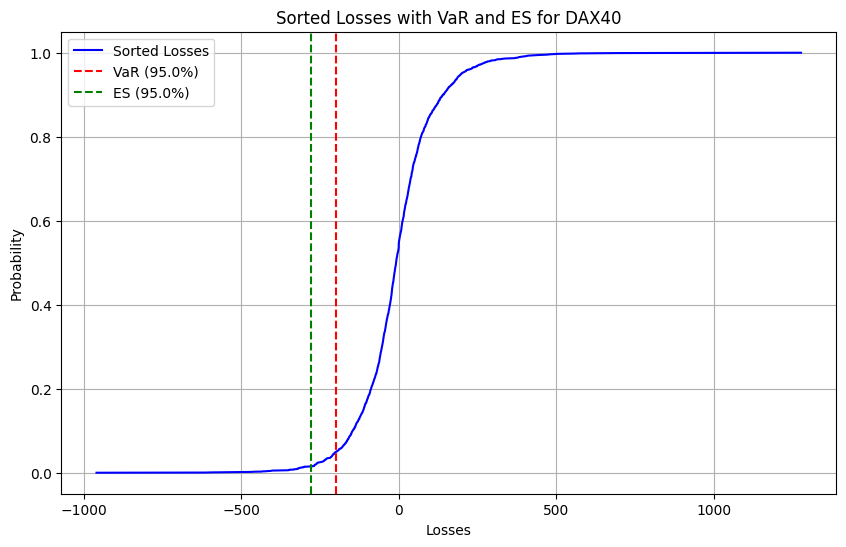

In [34]:
confidence_level = 0.95
# Extract historical losses for DAX40
dax40_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Dax40_Loss'].dropna()

# Sort the losses in ascending order
sorted_dax40_losses = dax40_losses.sort_values()

# Calculate the index for the VaR based on the confidence level
var_index_dax40 = int((1 - confidence_level) * len(sorted_dax40_losses))

# Calculate VaR
VaR_dax40 = sorted_dax40_losses.iloc[var_index_dax40]

# Calculate ES (average of losses beyond VaR)
ES_dax40 = sorted_dax40_losses.iloc[:var_index_dax40].mean()

print(f"VaR (DAX40) at {confidence_level * 100}% confidence level: {VaR_dax40}")
print(f"ES (DAX40) at {confidence_level * 100}% confidence level: {ES_dax40}")

import matplotlib.pyplot as plt

# Plot the sorted losses as a line graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_dax40_losses.values, np.linspace(0, 1, len(sorted_dax40_losses), endpoint=False), label='Sorted Losses', color='blue')

# Highlight VaR and ES on the graph
plt.axvline(x=VaR_dax40, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%)')
plt.axvline(x=ES_dax40, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%)')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Probability')
plt.title('Sorted Losses with VaR and ES for DAX40')
plt.legend()
plt.grid()
plt.show()

VaR (Nikkei) at 95.0% confidence level: -2.95889384
ES (Nikkei) at 95.0% confidence level: -4.263652923779528


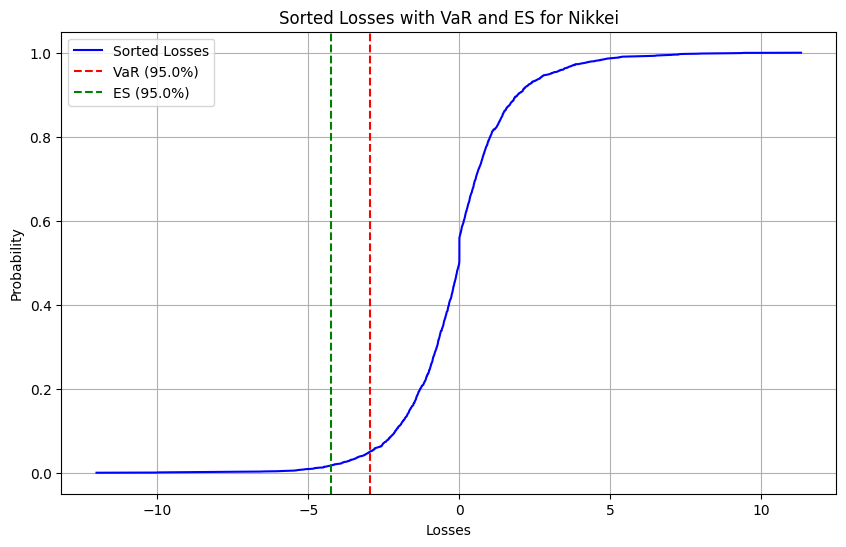

In [35]:
confidence_level = 0.95

# Extract historical losses for Nikkei
nikkei_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Nikkei_Loss'].dropna()

# Sort the losses in ascending order
sorted_nikkei_losses = nikkei_losses.sort_values()

# Calculate the index for the VaR based on the confidence level
var_index_nikkei = int((1 - confidence_level) * len(sorted_nikkei_losses))

# Calculate VaR
VaR_nikkei = sorted_nikkei_losses.iloc[var_index_nikkei]

# Calculate ES (average of losses beyond VaR)
ES_nikkei = sorted_nikkei_losses.iloc[:var_index_nikkei].mean()

print(f"VaR (Nikkei) at {confidence_level * 100}% confidence level: {VaR_nikkei}")
print(f"ES (Nikkei) at {confidence_level * 100}% confidence level: {ES_nikkei}")

import matplotlib.pyplot as plt

# Plot the sorted losses as a line graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_nikkei_losses.values, np.linspace(0, 1, len(sorted_nikkei_losses), endpoint=False), label='Sorted Losses', color='blue')

# Highlight VaR and ES on the graph
plt.axvline(x=VaR_nikkei, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%)')
plt.axvline(x=ES_nikkei, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%)')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Probability')
plt.title('Sorted Losses with VaR and ES for Nikkei')
plt.legend()
plt.grid()
plt.show()